# 1. Multi-class Classification and Neural Networks

<p style='text-align: justify;'>
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task. 

In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.
</p>

## 1.1 Dataset

<p style='text-align: justify;'>
    
**Matlab*/Octave**

You are given a data set in *ex3data1.mat* that contains *5000* training examples of handwritten digits. 2 The *.mat* format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the load command. After loading, matrices of the correct dimensions and values will appear in your program’s memory. The matrix will already be named, so you do not need to assign names to them.

```Matlab
% Load saved matrices from file
load('ex3data1.mat');
% The matrices X and y will now be in your Octave environment
```

**Python**

Since python doest read _*.mat_ files, we will read the function using the next line of code. Where _x_ contains a $5000 \times 400$ matrix holding the information for all the handwritten digits, and _y_ is a $5000$ element vector holding the class label for each digit.

</p>

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
data = sio.loadmat("../data/ex3data1.mat")
X = data["X"]
y = data["y"].flatten()

## Data Visualization

<p style='text-align: justify;'>
Reading in the given MATLAB file which contains 5000 training examples of handwritten digits taken from the MNIST handwritten digit dataset. According to the assignment documentation, take note that the 0 digit is given the label 10.
</p>

### Approach to visualizing a digit from an array of values

<p style='text-align: justify;'>

Each digit is an image size 20 by 20 pixels, where each pixel's intensity is represented by a floating point number. In constructing the X matrix, each digit's image was flattened into a 400 element vector and stored as a row in X.

The logic behind reconstructing a digit's image is therefore:

Index out a row vector from X.
Reshape that vector into a 20 by 20 matrix.
Transpose the matrix to obtain the image in the correct orientation.
Step (3) is necessary because MATLAB flattens arrays in column-major order. When reshapinag the image array (originally flattened in MATLAB), using numpy, numpy would reconstruct the 2D array in row-major order, so without a tranposition, the images would be flipped along the diagonal. I was reminded of this when an initial visualization of the images did not appear right, but was fixed after a transpose. 
    
To visualize our data, we have to do the following:
1. First, construct a figure of size 8x8 inches, that has 100 subplots, with 10 subplots in the vertical direction, and 10 subplots in the horizontal direction. Each subplot will be an image of a digit.
- A digit is randomly chosen by randomly indexing a row vector from X.
- An Axes object is selected from axes array and the row vector is reshaped, transposed and passed to imshow() called on the Axes object. The additional argument cmap="Greys_r" makes the digits white against a black background.
- The number markings on the x and y axes are then removed as it is images that we are visualizing.

The axes are a 10 by 10 numpy array of Axes objects. Using a double for loop, It'll iteratively populate the figure fig with images of the digits rendered.
</p>

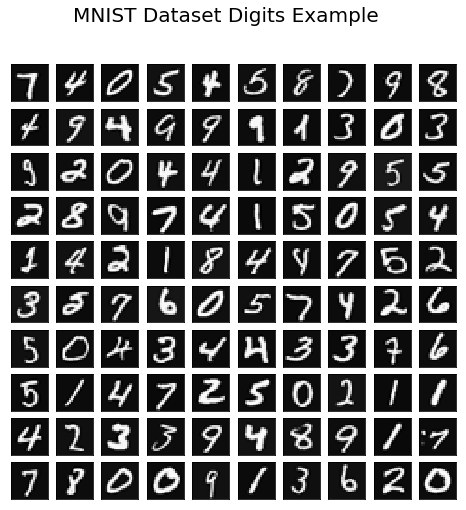

In [4]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize = (8,8))
fig.suptitle("MNIST Dataset Digits Example", fontsize = 20)
for i in range(0,10):
    for j in range(0,10):
        row = np.random.randint(low=0, high =5000)
        axes[i][j].imshow(X[row,:].reshape(20,20).T, cmap="Greys_r")
        axes[i][j].set(xticks=[], yticks=[])

## 2. Regularized Logistic Regression in Vectorized Form

### 2.1 Lamda Function

In [5]:
sigmoid = lambda z : 1/(1 + np.exp(z))

### 2.2 Cost Function

In [6]:
def compute_cost_regularized(theta, X, y, lda):
    reg =lda/(2*len(y)) * np.sum(theta[1:]**2) 
    return 1/len(y) * ( -y @ np.log(sigmoid(X@theta)) - (1-y) @ np.log(1-sigmoid(X@theta)) ) + reg

### 2.3 Gradient Descent Regularized

In [7]:
def compute_gradient_regularized(theta, X, y, lda):
    gradient = np.zeros(len(theta))
    XT = X.T
    beta = sigmoid(X@theta) - y
    regterm = lda/len(y) * theta
    # theta_0 does not get regularized, so a 0 is substituted in its place
    regterm[0] = 0 
    gradient = (1/len(y) * XT@beta).T + regterm
    return gradient

In [8]:
theta_test = np.array([-2,-1,1,2])
X_test = np.concatenate((np.ones((5,1)), 
            np.fromiter((x/10 for x in range(1,16)), float).reshape((3,5)).T), 
                        axis =1)
y_test = np.array([1,0,1,0,1])
lambda_test = 3

In [9]:
compute_cost_regularized(theta_test, X_test, y_test,lambda_test)

2.754819396109744

In [10]:
compute_gradient_regularized(theta_test,X_test,y_test,lambda_test)

array([-0.34656137, -0.71144159,  0.31527773,  0.74199704])

## One-vs-all Classification with Logistic Regression

In [11]:
X_bias = np.concatenate((np.ones(X.shape[0]).reshape(X.shape[0],1),X),axis = 1)
print(X_bias.shape)
X_bias[0:3]

(5000, 401)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
def train_one_vs_all(X, y, opt_method):
    theta_all = np.zeros((y.max()-y.min()+1, X.shape[1]))
    for k in range(y.min(),y.max()+1):
        grdtruth = np.where(y==k, 1,0)
        results = minimize(compute_cost_regularized, theta_all[k-1,:], 
                           args = (X,grdtruth,0.1),
                           method = opt_method, 
                           jac = compute_gradient_regularized)
        # optimized parameters are accessible through the x attribute
        theta_optimized = results.x
        # Assign thetheta_optimized vector to the appropriate row in the 
        # theta_all matrix
        theta_all[k-1,:] = theta_optimized
    return theta_all

In [13]:
theta_all_optimized_cg = train_one_vs_all(X_bias, y, 'CG')  # Optimization performed using Conjugate Gradient
theta_all_optimized_bfgs = train_one_vs_all(X_bias, y, 'BFGS') # optimization performed using Broyden–Fletcher–Goldfarb–Shanno

### One-vs-all Prediction

As usual, we set up the model/design matrix, X_bias by inserting a column of ones to accomodate the bias term $\theta_0$ in our model.



In [14]:
def predict_one_vs_all(X, theta):
    return np.mean(np.argmax(sigmoid(X@theta.T), axis=1)+1 == y)*100

In [15]:
predict_one_vs_all(X_bias, theta_all_optimized_cg)

10.0

In [16]:
predict_one_vs_all(X_bias, theta_all_optimized_bfgs)

10.0

#### Conjugate Gradient does not converge as well as BFGS

In [17]:
theta_all_optimized_bfgs_from_cg = np.copy(theta_all_optimized_cg)

for k in range(y.min(),y.max()+1):
    grdtruth = np.where(y==k, 1,0)
    results = minimize(compute_cost_regularized, theta_all_optimized_bfgs_from_cg[k-1,:], 
                           args = (X_bias,grdtruth,0.1),
                           method = "BFGS", 
                           jac = compute_gradient_regularized)
        # optimized parameters are accessible through the x attribute
    theta_optimized = results.x
        # Assign thetheta_optimized vector to the appropriate row in the 
        # theta_all matrix
    theta_all_optimized_bfgs_from_cg[k-1,:] = theta_optimized

predict_one_vs_all(X_bias, theta_all_optimized_bfgs_from_cg)

10.0